## Introduction

This notebook demonstrates a deep learning approach for face mask detection. We will be using a pre-trained convolutional neural network (CNN) model, specifically VGG19, and training it on a dataset of images containing faces with and without masks.

The goal is to build a model that can accurately identify whether a person in an image is wearing a face mask.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

The dataset used for this project is downloaded from Kaggle, specifically from the following sources:

- "https://www.kaggle.com/datasets/andrewmvd/face-mask-detection"
- "https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset"

The dataset is organized into training, testing, and validation sets, which are stored in Google Drive in this example.

In [2]:
TRAIN_PATH = "/content/drive/MyDrive/facemaskdataset/FMD/Train"
TEST_PATH = "/content/drive/MyDrive/facemaskdataset/FMD/Test"
VAL_PATH = "/content/drive/MyDrive/facemaskdataset/FMD/Validation"

In [3]:
import numpy as np #Library that is used for dealing with arrays
import matplotlib.pyplot as plt #Library that is used for plotting
import keras #Deep learning framework
from keras.layers import * #allows me to import the layers (CNN building blocks) from keras framework
from keras.models import * #import different keras models
from keras.preprocessing import image #helps me on data augmentation

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance


In [ ]:
## Model Architecture and Data Preparation

This section focuses on building the deep learning model for face mask classification and preparing the image data for training.

We utilize the VGG19 architecture as a base, removing its top layers and adding our own layers for classification. Data augmentation is also applied to the training data to improve the model's robustness.

## Face Detection with Haar Cascades

Before building the deep learning model for mask detection, we first need to be able to detect faces within an image. This section uses Haar Cascades, a machine learning object detection approach, to identify the locations of faces.

We load a pre-trained Haar Cascade classifier for frontal faces and demonstrate its usage on a sample image by drawing rectangles around the detected faces.

In [5]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

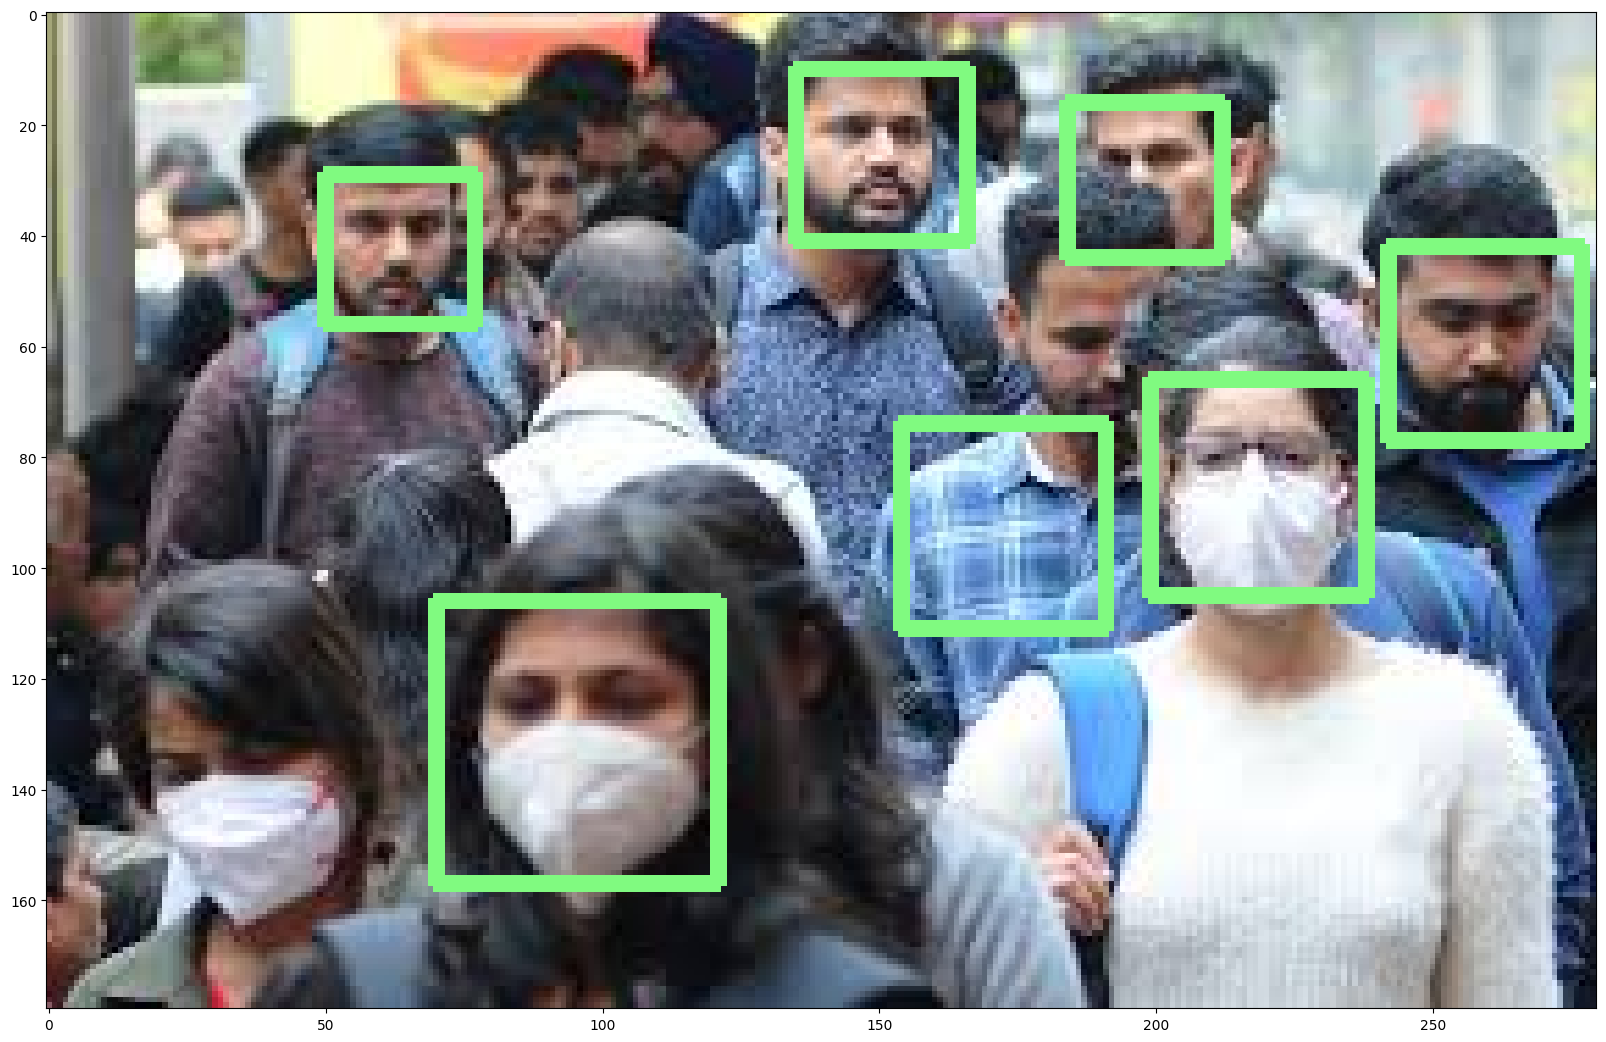

In [6]:
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

#trying it out on a sample image
img = cv2.imread('/content/drive/MyDrive/facemaskdataset/FMD/images.jpg')

gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_cascade.detectMultiScale(gray,scaleFactor=1.08, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(128,250,128),2)
plt.figure(figsize=(20,20))
plt.imshow(out_img)

## Model Architecture and Data Preparation

This section focuses on building the deep learning model for face mask classification and preparing the image data for training.

We utilize the VGG19 architecture as a base, removing its top layers and adding our own layers for classification. Data augmentation is also applied to the training data to improve the model's robustness.

In [7]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=TEST_PATH,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=VAL_PATH,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 2500 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


In [9]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        16,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,040,770 (76.45 MB)

 Trainable params: 16,386 (64.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [10]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])

In [11]:
history = model.fit(train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 133s 129s/step - accuracy: 0.4167 - loss: 0.8864 - val_accuracy: 0.6083 - val_loss: 0.6708
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 137s 129s/step - accuracy: 0.6354 - loss: 0.6771 - val_accuracy: 0.5667 - val_loss: 0.6643
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 157s 149s/step - accuracy: 0.6354 - loss: 0.5911 - val_accuracy: 0.5164 - val_loss: 0.7546
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 128s 121s/step - accuracy: 0.6875 - loss: 0.5926 - val_accuracy: 0.8862 - val_loss: 0.3343
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 121s 113s/step - accuracy: 0.8958 - loss: 0.3239 - val_accuracy: 0.8731 - val_loss: 0.3182
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 157s 148s/step - accuracy: 0.7812 - loss: 0.4090 - val_accuracy: 0.8731 - val_loss: 0.3054
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 120s 112s/step - accuracy: 0.9688 - loss: 0.1964 - val_accuracy: 0.8928 - val_loss: 0.2452
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 120s 112s/step - accuracy: 0.9167 - loss: 0.2048 - val_accuracy: 0.8928 - v

## Results and Prediction

This section shows how to use the trained model to make predictions on new images and visualize the results. We will test the model on sample images and display whether a mask is detected around the faces.

In [13]:
model.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 10s/step - accuracy: 0.9217 - loss: 0.1821


[0.18522264063358307, 0.9200000166893005]

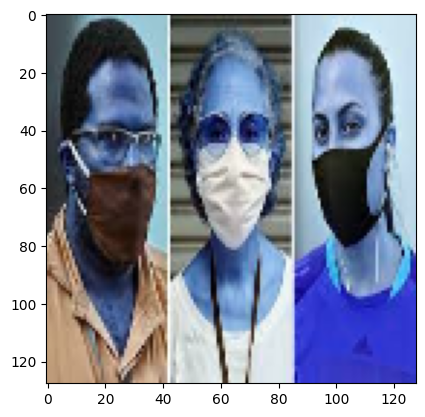

In [14]:
sample_mask_img = cv2.imread('/content/drive/MyDrive/facemaskdataset/FMD/test1.jfif')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [15]:
model.predict(sample_mask_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


array([[0.93010944, 0.03015393]], dtype=float32)

In [18]:
model.save('masknet.keras')

In [19]:
mask_label = {
    0:'MASK',
    1:'NO MASK'
             }
rect_label = {
    0:(0,250,0),
    1:(250,0,0)
             }

In [20]:
def show_results(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

    label = [0 for i in range(len(faces))]
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    counter_masks = {
        'has_mask': 0,
        'no_mask': 0
    }
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]

        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0

        mask_result = model.predict(crop)
        has_mask = mask_result.argmax()

        if has_mask==0:
            counter_masks['has_mask'] += 1
        else:
            counter_masks['no_mask'] += 1

        cv2.putText(new_img,mask_label[has_mask],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,rect_label[has_mask],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),rect_label[has_mask],1)

    plt.figure(figsize=(10,10))
    annot1 = f"People with MASKS: {counter_masks['has_mask']};"
    annot2 = f"People with NO MASKS: {counter_masks['no_mask']}."
    cv2.putText(new_img,text=annot1,org=(10, 10),fontFace=cv2.FONT_HERSHEY_TRIPLEX,fontScale=0.5,color=(255, 255, 255),thickness=1)
    cv2.putText(new_img,text=annot2,org=(10, 30),fontFace=cv2.FONT_HERSHEY_TRIPLEX,fontScale=0.5,color=(255, 255, 255),thickness=1)
    plt.imshow(new_img)

In [21]:
import random
import glob

/content/drive/MyDrive/facemaskdataset/FMD/images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
/content/drive/MyDrive/facemaskdataset/FMD/test1.jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
/content/drive/MyDrive/facemaskdataset/FMD/test2.jfif
/content/drive/MyDrive/facemaskdataset/FMD/test3.jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
/content/drive/MyDrive/facemaskdataset/FMD/test4.jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
/content/drive/MyDrive/facemaskdataset/FMD/test5.jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


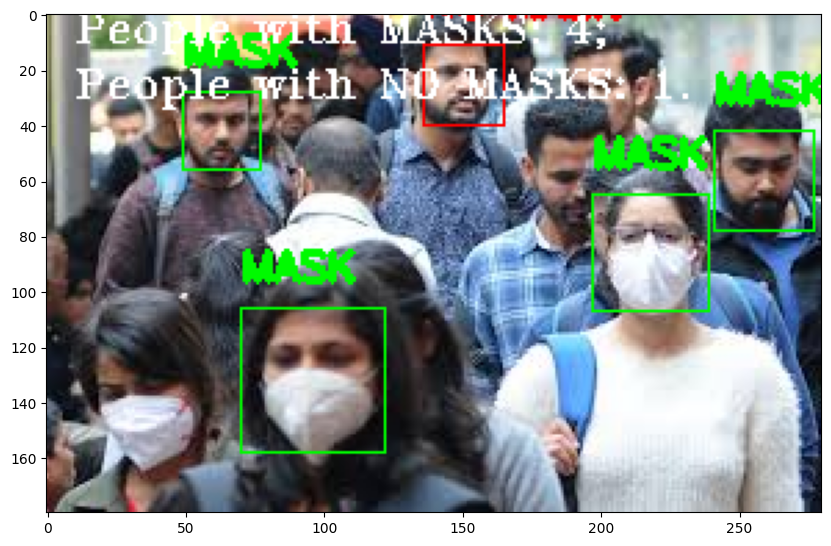

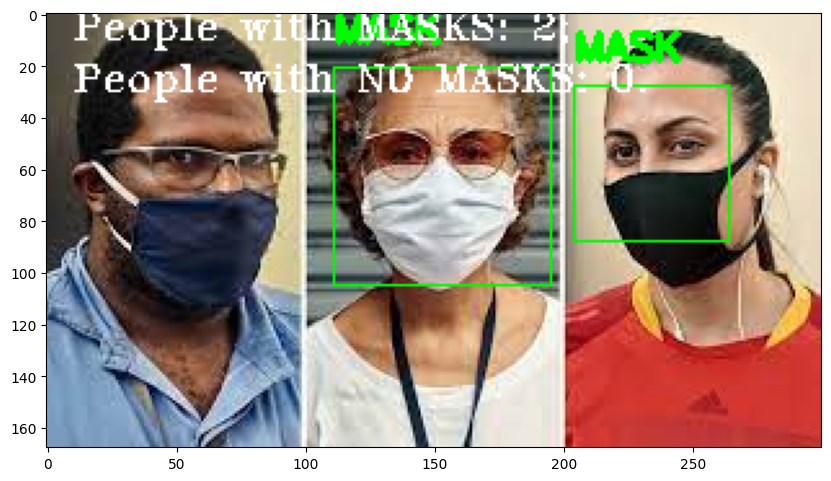

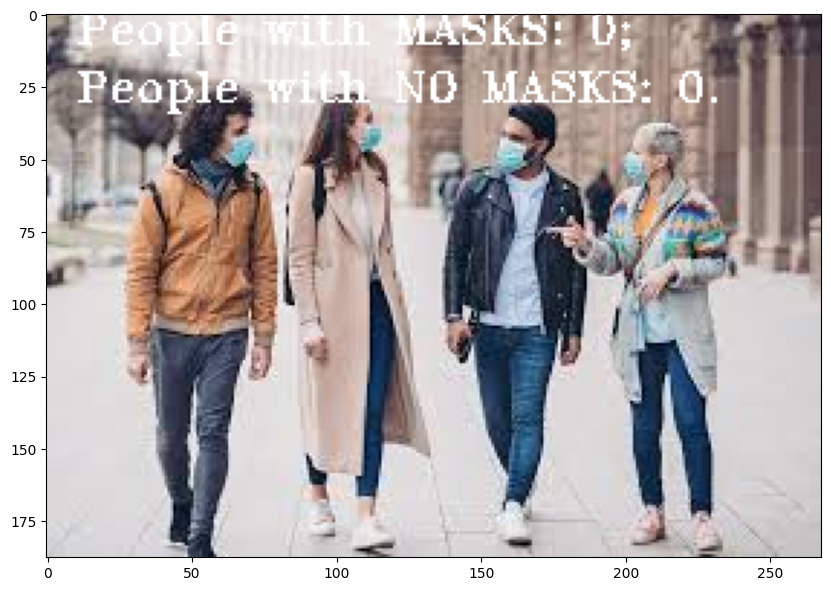

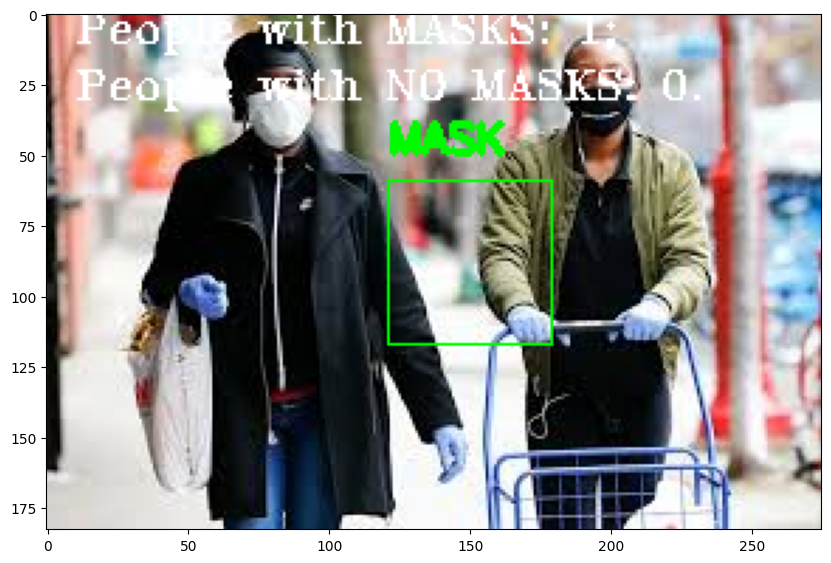

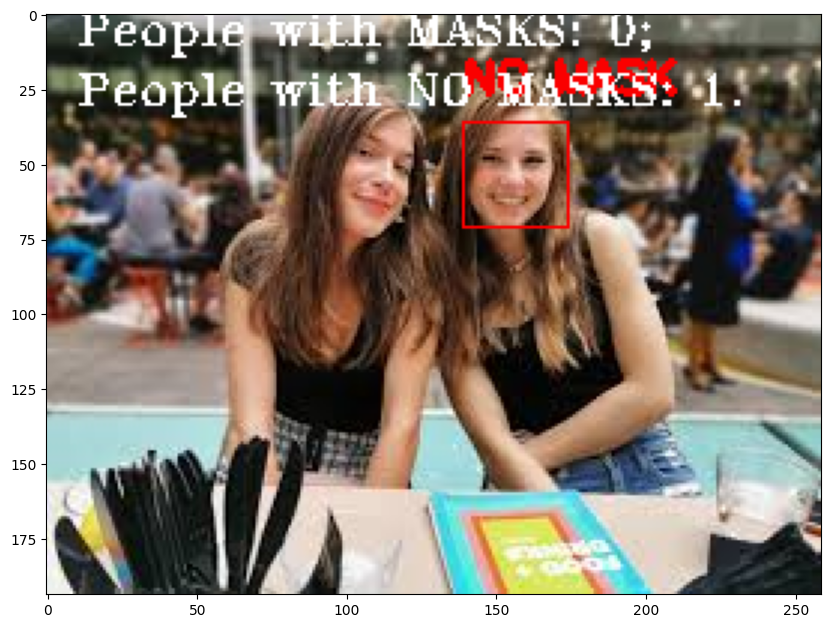

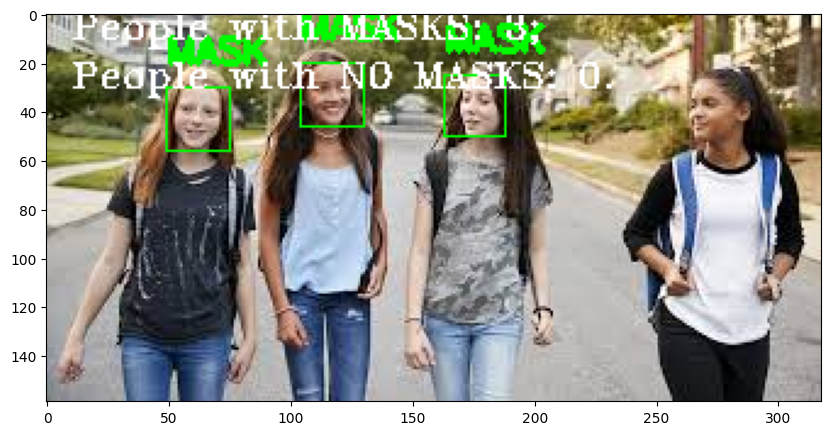

In [22]:
good_preds = [
'/content/drive/MyDrive/facemaskdataset/FMD/images.jpg',
'/content/drive/MyDrive/facemaskdataset/FMD/test1.jfif',
'/content/drive/MyDrive/facemaskdataset/FMD/test2.jfif',
'/content/drive/MyDrive/facemaskdataset/FMD/test3.jfif',
'/content/drive/MyDrive/facemaskdataset/FMD/test4.jfif',
'/content/drive/MyDrive/facemaskdataset/FMD/test5.jfif']

for p in good_preds:
    print(p)
    show_results(p)

/content/drive/MyDrive/facemaskdataset/FMD/test3.jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
/content/drive/MyDrive/facemaskdataset/FMD/test3.jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
/content/drive/MyDrive/facemaskdataset/FMD/test3.jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
/content/drive/MyDrive/facemaskdataset/FMD/test3.jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
/content/drive/MyDrive/facemaskdataset/FMD/test3.jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


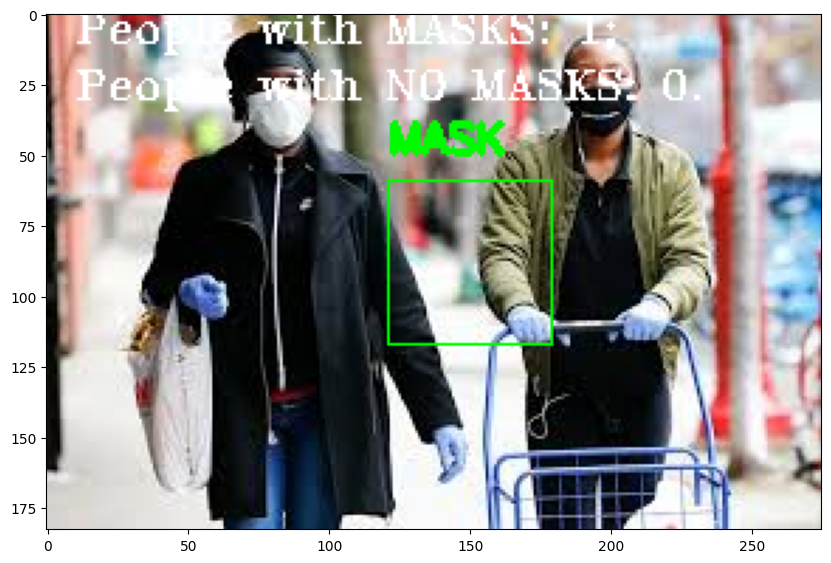

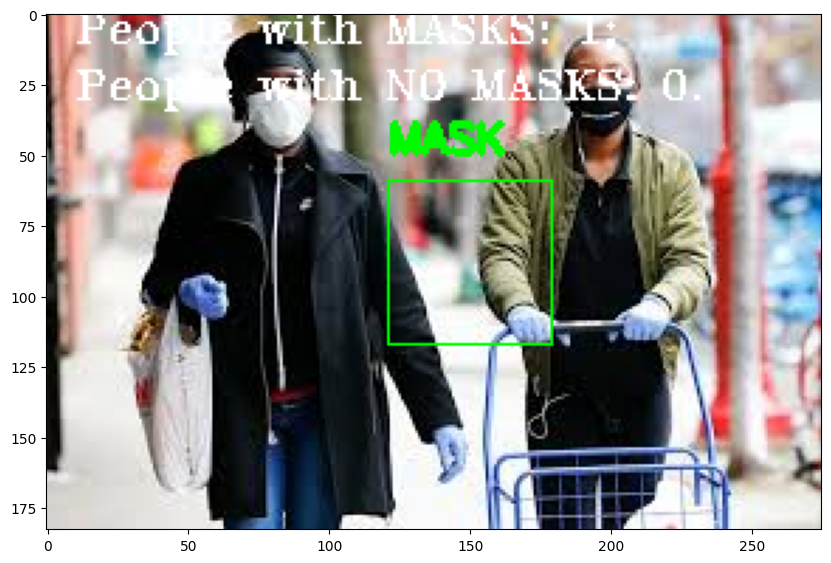

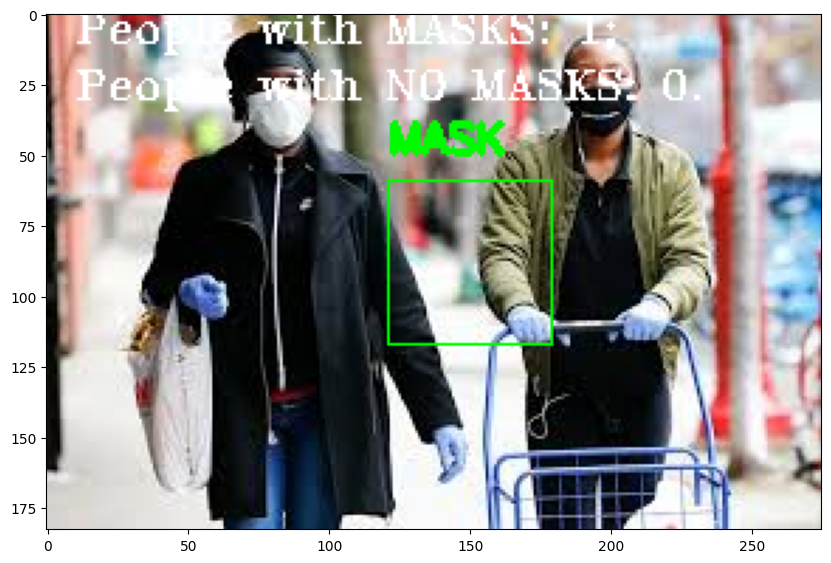

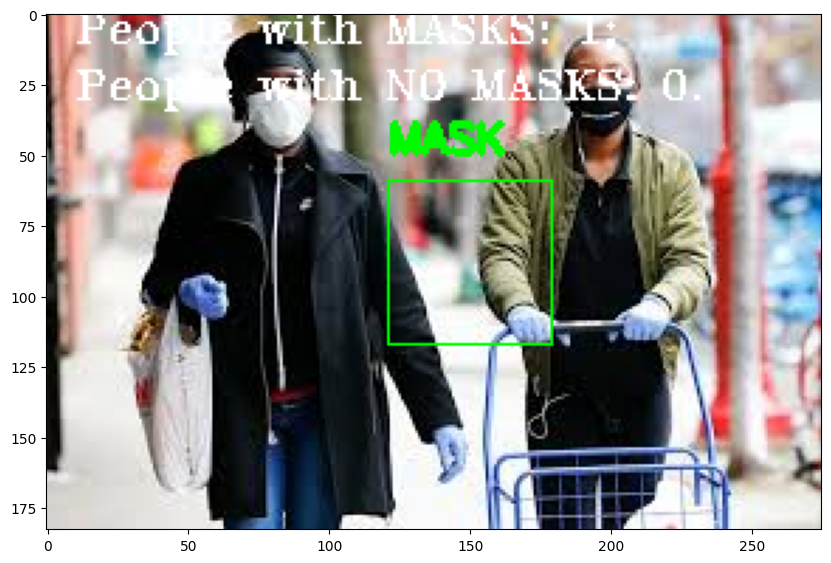

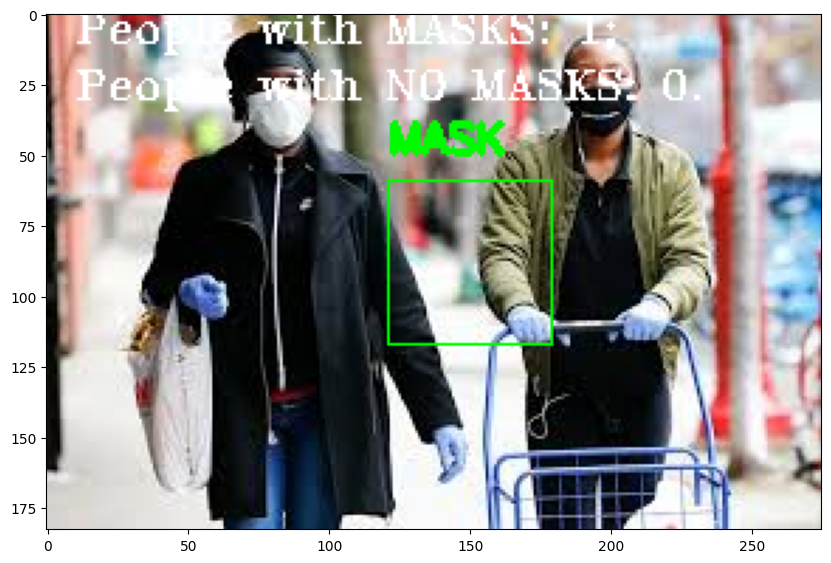

In [23]:
some_img = glob.glob("/content/drive/MyDrive/facemaskdataset/FMD/test3.jfif")

for p in random.choices(some_img, k=5):
    print(p)
    show_results(p)